In [5]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Demo—Taste of Cheese

Adapted from [Unit 6: cheese.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit6/cheese.odc).

The link in the original .odc file is dead. I downloaded the data from [here](https://www3.nd.edu/~busiforc/handouts/Data%20and%20Stories/multicollinearity/Cheese%20Taste/Cheddar%20Cheese%20Data.html) and have a copy [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/cheese.csv).

Associated lecture videos: Unit 6, Lessons 5 and 8.

## Problem statement

As cheddar cheese matures, a variety of chemical processes take place. The taste of matured cheese is related to the concentration of several chemicals in the final product. In a study of cheddar cheese from the LaTrobe Valley of Victoria, Australia, samples of cheese were analyzed for their chemical composition and were subjected to taste tests. Overall taste scores were obtained by combining the scores from several tasters.

Can the score be predicted well by the predictors: Acetic, H2S, and Lactic?

In [2]:
data = pd.read_csv("../data/cheese.csv", index_col=0)
X = data[["Acetic", "H2S", "Lactic"]].to_numpy()
# add intercept column to X
X_aug = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = data["taste"].to_numpy()

In [3]:
data

,taste,Acetic,H2S,Lactic
1,12.3,4.543,3.135,0.86
2,20.9,5.159,5.043,1.53
3,39.0,5.366,5.438,1.57
4,47.9,5.759,7.496,1.81
5,5.6,4.663,3.807,0.99
6,25.9,5.697,7.601,1.09
7,37.3,5.892,8.726,1.29
8,21.9,6.078,7.966,1.78
9,18.1,4.898,3.850,1.29
10,21.0,5.242,4.174,1.58


In [4]:
X_aug

array([[ 1.   ,  4.543,  3.135,  0.86 ],
       [ 1.   ,  5.159,  5.043,  1.53 ],
       [ 1.   ,  5.366,  5.438,  1.57 ],
       [ 1.   ,  5.759,  7.496,  1.81 ],
       [ 1.   ,  4.663,  3.807,  0.99 ],
       [ 1.   ,  5.697,  7.601,  1.09 ],
       [ 1.   ,  5.892,  8.726,  1.29 ],
       [ 1.   ,  6.078,  7.966,  1.78 ],
       [ 1.   ,  4.898,  3.85 ,  1.29 ],
       [ 1.   ,  5.242,  4.174,  1.58 ],
       [ 1.   ,  5.74 ,  6.142,  1.68 ],
       [ 1.   ,  6.446,  7.908,  1.9  ],
       [ 1.   ,  4.477,  2.996,  1.06 ],
       [ 1.   ,  5.236,  4.942,  1.3  ],
       [ 1.   ,  6.151,  6.752,  1.52 ],
       [ 1.   ,  6.365,  9.588,  1.74 ],
       [ 1.   ,  4.787,  3.912,  1.16 ],
       [ 1.   ,  5.412,  4.7  ,  1.49 ],
       [ 1.   ,  5.247,  6.174,  1.63 ],
       [ 1.   ,  5.438,  9.064,  1.99 ],
       [ 1.   ,  4.564,  4.949,  1.15 ],
       [ 1.   ,  5.298,  5.22 ,  1.33 ],
       [ 1.   ,  5.455,  9.242,  1.44 ],
       [ 1.   ,  5.855, 10.199,  2.01 ],
       [ 1.   , 

(array([5.30000e+01, 1.78100e+03, 2.43290e+04, 1.38606e+05, 3.31282e+05,
        3.33324e+05, 1.43036e+05, 2.55610e+04, 1.96900e+03, 5.90000e+01]),
 array([-15.29248827, -12.2418099 ,  -9.19113153,  -6.14045315,
         -3.08977478,  -0.03909641,   3.01158197,   6.06226034,
          9.11293871,  12.16361709,  15.21429546]),
 <BarContainer object of 10 artists>)

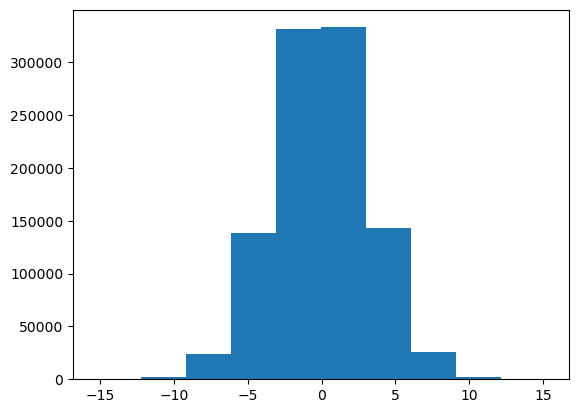

In [10]:
vals = pm.draw(pm.Normal.dist(mu=0, tau=0.001), 1000000)

plt.hist(vals)

In [20]:
with pm.Model() as m:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_aug, mutable=True)
    y_data = pm.Data("y", y, mutable=False)

    # priors
    beta = pm.Normal("beta", mu=0, sigma=1000, shape=X.shape[1] + 1)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    mu = pm.math.dot(X_data, beta)

    # likelihood
    pm.Normal("taste_score", mu=mu, sigma=sigma, observed=y_data)

    # start sampling
    trace = pm.sample(5000, target_accept=0.95)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, tau]
INFO:pymc:NUTS: [beta, tau]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_tre

In [18]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-28.975,20.013,-68.339,10.446,0.234,0.165,7342.0,9821.0,1.0
beta[1],0.318,4.533,-8.505,9.357,0.054,0.039,7145.0,9300.0,1.0
beta[2],3.910,1.271,1.398,6.378,0.012,0.009,10419.0,11096.0,1.0
beta[3],19.772,8.872,2.376,37.434,0.088,0.064,10138.0,11036.0,1.0
tau,0.010,0.003,0.005,0.015,0.000,0.000,9946.0,10006.0,1.0
sigma,10.450,1.530,7.734,13.589,0.016,0.011,9946.0,10006.0,1.0


TypeError: r2_score() missing 1 required positional argument: 'y_pred'

Results are pretty close to OpenBUGS:

|         mean |     sd   |        MC_error |   val2.5pc | median  |   val97.5pc | start   | sample |        |
|--------------|----------|-----------------|------------|---------|-------------|---------|--------|--------|
| beta0        | -29.75   | 20.24           | 0.7889     | -70.06  | -29.75      | 11.11   | 1000   | 100001 |
| beta1        | 0.4576   | 4.6             | 0.189      | -8.716  | 0.4388      | 9.786   | 1000   | 100001 |
| beta2        | 3.906    | 1.291           | 0.02725    | 1.345   | 3.912       | 6.47    | 1000   | 100001 |
| beta3        | 19.79    | 8.893           | 0.2379     | 2.053   | 19.88       | 37.2    | 1000   | 100001 |
| tau          | 0.009777 | 0.002706        | 2.29E-05   | 0.00522 | 0.009528    | 0.01575 | 1000   | 100001 |

PyMC gives some warnings about the model unless we increase the ```target_accept``` parameter of ```pm.sample```, while BUGS doesn't. This is because PyMC uses more diagnostics to check if there are any problems with its exploration of the parameter space. Divergences indicate bias in the results. BUGS will happily run this model without reporting any problems, but it doesn't mean that there aren't any.

For further reading, check out [Diagnosing Biased Inference with Divergences](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html).

It looks like there are multiple ways to get predictions on out-of-sample data in PyMC. The easiest way is to set up a shared variable using pm.Data in the original model, then using pm.set_data to change to the new observations before calling pm.sample_posterior_predictive.

In [5]:
# single prediction on out-of-sample data
new_obs = np.array([[1.0, 5.0, 7.1, 1.5]])
pm.set_data({"X": new_obs}, model=m)
ppc = pm.sample_posterior_predictive(trace, model=m, predictions=True)

The default behavior now is to give one prediction per y-value. The professor often asks for a single prediction based on the new data; the equivalent here would be to take the mean of the predicted values.

In [6]:
az.summary(ppc.predictions, hdi_prob=0.95).mean()

mean            30.017800
sd              11.217567
hdi_2.5%         7.822233
hdi_97.5%       52.016233
mcse_mean        0.084767
mcse_sd          0.060000
ess_bulk     17495.633333
ess_tail     18667.900000
r_hat            1.000000
dtype: float64

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sat Mar 18 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

pytensor: 2.10.1

numpy : 1.24.2
pandas: 1.5.3
arviz : 0.14.0
pymc  : 5.1.1

